In [22]:
import numpy as np
from numpy import einsum, ones, var, pi, log, zeros, eye, diag
from numpy.linalg import det, inv
from numpy.random import shuffle
import matplotlib.pyplot as plt
import matplotlib.cm
import scipy.stats as stats
import scipy.special as special
from scipy.special import digamma, gamma
import sklearn.datasets
import random
plt.rcParams['figure.figsize'] = (8,6)

In [71]:
class VI: 
    def __init__(self, dimensions, data, colors, clusters = 100, alpha = 1, beta = 1, nu = 3, minPc = 0.01): 
        self.D, self.X, self.N, self.K = dimensions, data, len(data), clusters
        self.colors = colors
        self.alpha, self.beta, self.nu = alpha*ones(self.K), beta*ones(self.K), nu*ones(self.K) #hyperparameters alpha, beta, nu
        self.m = einsum('i,k->ki', np.mean(self.X, axis = 0), ones(self.K)) + 10*(np.random.random(size = (self.K, self.D))-0.5)
            #m[k] is the MLE for the prior on mean k, so we'll use m to represent the means. 
        self.W = einsum('i,jk->ijk', ones(self.K), diag(1./var(self.X.T, axis = 1))) #hyperparameter W starts as sample precision
        self.elim = True
        self.iteration = 0
        self.r = None
        self.rSet = False
        self.logMinPc = log(minPc) #minimum percent for a Gaussian to not be pruned

    def E(self): 
        D, X, N, K, alpha, beta, nu, m, W = self.D, self.X, self.N, self.K, self.alpha, self.beta, self.nu, self.m, self.W
        sumalpha = sum(alpha)
        E_ln_pi = digamma(alpha) - digamma(sumalpha)
        
                
        if self.elim and self.iteration > 0: 
            keep = E_ln_pi > self.logMinPc
            #-7 = 0.1%, -6 = 0.25%, -5 = 0.67%, -4 = 1.8%, -3 = 5%
            #20% = -1.6094, 10% = -2.3026, 5% = -2.9957
            k = np.sum(keep)
            if k == 0: 
                print("Wanted to prune all clusters...")
                k = K
            if k != K: 
                if K-k > 4: 
                    for i in range(K): 
                        if not keep[i]: 
                            if random.random() < 0.5: 
                                keep[i] = True
                    k = np.sum(keep)
                self.alpha = alpha[keep]
                self.beta = beta[keep]
                self.nu = nu[keep]
                self.m = m[keep]
                self.W = W[keep]
                if K == k+1: 
                    print(f"Eliminated 1 cluster on iteration {self.iteration+1}. {k} remaining.")
                else: 
                    print(f"Eliminated {K - k} clusters on iteration {self.iteration+1}. {k} remaining.")
                self.K = k
                D, X, N, K, alpha, beta, nu, m, W = self.D, self.X, self.N, self.K, self.alpha, self.beta, self.nu, self.m, self.W
                sumalpha = sum(alpha)
                E_ln_pi = digamma(alpha) - digamma(sumalpha)

        E_ln_Lambda = D * log(2) + log(det(W)) + sum(digamma((nu+1-i)/2) for i in range(1, D+1))

        temp = einsum('ijk->jki',np.subtract.outer(X, m)[:,range(D),:,range(D)])
        EmL_Prod = einsum('i,j->ij', D/beta, ones(N)) + einsum('k,nki,kij,nkj->kn', nu, temp, W, temp)
        
        ln_rho = einsum('i,j->ij', (E_ln_pi + 0.5 * E_ln_Lambda), ones(N)) - D/2 * log(2*pi) - 0.5 * EmL_Prod

        p = np.exp(ln_rho.T)
        r = p/np.einsum('i,j->ij', np.sum(p, axis = 1), np.ones(K))
        self.r = r
        self.rSet = True
        #print(r)
        
        #get inferential statistics from responsibilities
        N_ = np.sum(r, axis=0)
        xbar = np.einsum('ij,ik->jk', r, X)*np.einsum('i,j->ij', 1./N_, np.ones(D))
        temp = einsum('ijk->jki',np.subtract.outer(X, xbar)[:,range(D),:,range(D)])
        S = einsum('nk,nki,nkj->kij', r, temp, temp) * einsum('i,j,k->ijk', 1./N_, ones(D), ones(D))
        
        return N_, xbar, S
        
    def M(self, N_, xbar, S): 
        alpha0, self.alpha = self.alpha, self.alpha + N_
        beta0, self.beta = self.beta, self.beta + N_
        m0, self.m = self.m, einsum('i,j->ij', 1./self.beta, ones(self.D)) * (np.einsum('i,ij->ij', beta0, self.m) + np.einsum('i,ij->ij', N_, xbar))
        W0, self.W = self.W, inv(inv(self.W) + np.einsum('k,kij->kij', N_, S) + np.einsum('i,ijk->ijk', (N_ * beta0 / (N_ + beta0)), np.einsum('kd,ke->kde', xbar-m0, xbar-m0))) #ouch
        nu0, self.nu = self.nu, self.nu + N_ + 1
        self.iteration += 1
        return N_, xbar, S, alpha0, beta0, m0, W0, nu0
    
    def plot(self, means = False, contours = False): 
        print(f"Iteration {self.iteration}")
        plt.scatter(self.X.T[0], self.X.T[1], c = self.colors)
        if means: 
            if not self.rSet: 
                plt.scatter(self.m.T[0], self.m.T[1], c = 'r', marker = '*')
            else: 
                plt.scatter(self.m.T[0], self.m.T[1], 4*np.sum(self.r, axis = 0)**2, c = 'r', marker = '*')
        if contours: 
            pdf = lambda x: sum([stats.multivariate_normal(mean = self.m[k], cov = inv(self.W[k])/self.nu[k]).pdf(x) for k in range(self.K)])
            Mg = np.meshgrid(np.arange(self.X[:,0].min()-2, self.X[:,0].max()+2, 0.1), np.arange(self.X[:,1].min()-2, self.X[:,1].max()+2, 0.1))
            Z = pdf(np.array(Mg).reshape(2, Mg[0].size).T).reshape(Mg[0].shape)
            plt.contour(Mg[0], Mg[1], Z, levels = [0.0001, 0.001, 0.01, 0.1, 1], colors = list(map(matplotlib.cm.get_cmap("viridis"), [1.0, 0.75, 0.5, 0.25, 0])))
        plt.show()
    
    def classifyPoints(self, plot = False): 
        L = [np.argmax([stats.multivariate_normal(mean = self.m[k], cov = inv(self.W[k])/self.nu[k]).pdf(x) for k in range(self.K)])+1 for x in X]
        if not plot: 
            return L
        plt.scatter(X[:,0], X[:,1], c = L, cmap = 'nipy_spectral')
        plt.scatter(self.m.T[0], self.m.T[1], 50, c = 'r', marker = '*')
        plt.show()
        
    def getELBO(self, N_, xbar, S, alpha0, beta0, m0, W0, nu0): 
        alpha, beta, W, m, nu = self.alpha, self.beta, self.W, self.m, self.nu
        D, N, K = self.D, self.N, self.K
        alpha00, nu00, W00 = np.mean(alpha0), np.mean(nu0), np.mean(W0) #??
        E_ln_pi = digamma(self.alpha) - digamma(sum(self.alpha))
        E_ln_Lambda = self.D * log(2) + log(det(self.W)) + sum(digamma((self.nu+1-i)/2) for i in range(1, self.D+1))
        L = 0.5 * np.sum(N_ * E_ln_Lambda - self.D/self.beta - self.nu * np.array([np.trace(S[k] @ self.W[k]) for k in range(self.K)])
                         - einsum('ki,kij,kj->k', xbar-self.m, self.W, xbar-self.m) - self.D*log(2*pi))
        L += np.sum(self.r * E_ln_pi)
        L += special.loggamma(np.sum(alpha0)) - np.sum(special.loggamma(alpha0)) + (alpha00-1)*np.sum(E_ln_pi) 
        L += K*(-nu00*log(det(W00))/2) + (nu00-D-1)/2*np.sum(E_ln_Lambda)-0.5*np.sum(nu * np.trace(inv(W0)@W)) #not finished
        #not finished...
        return L
    
    def iterate(self, num, plotNums): 
        for i in range(num): 
            self.M(*self.E())
            if i in plotNums: 
                self.plot(True, True)

Data


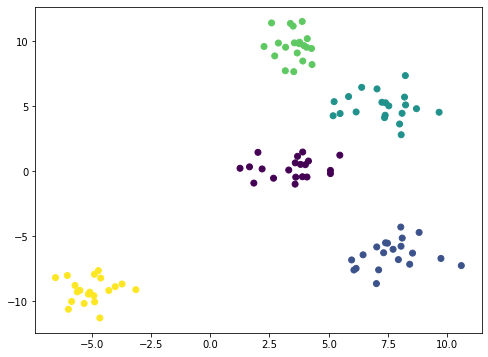

Iteration 1


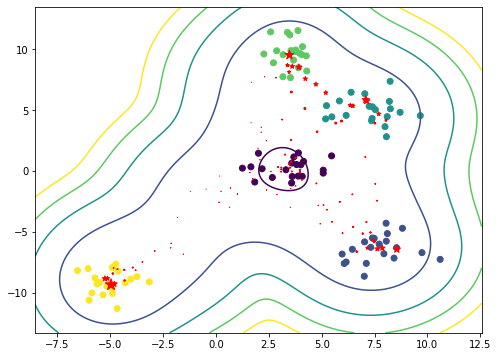

Wanted to prune all clusters...
Iteration 2


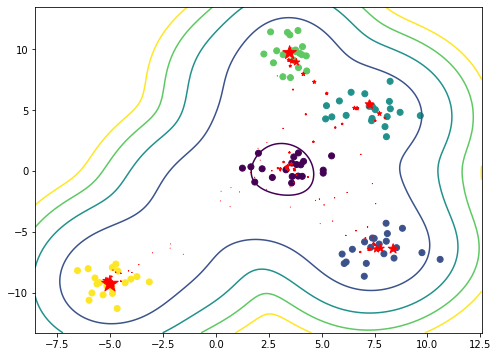

Eliminated 47 clusters on iteration 3. 53 remaining.
Eliminated 26 clusters on iteration 4. 27 remaining.
Iteration 4


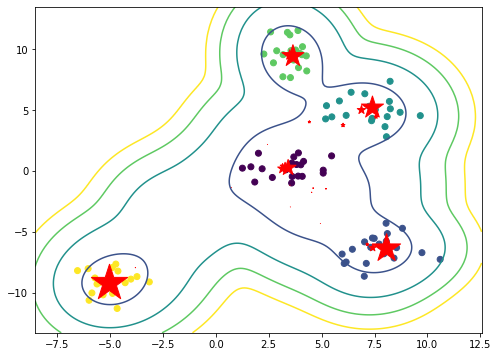

Eliminated 7 clusters on iteration 5. 20 remaining.
Eliminated 4 clusters on iteration 6. 16 remaining.
Eliminated 6 clusters on iteration 7. 10 remaining.
Eliminated 2 clusters on iteration 8. 8 remaining.
Iteration 10


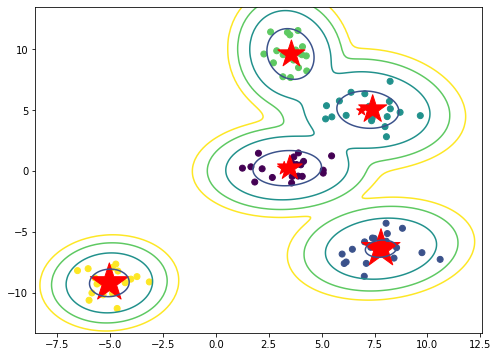

Iteration 100


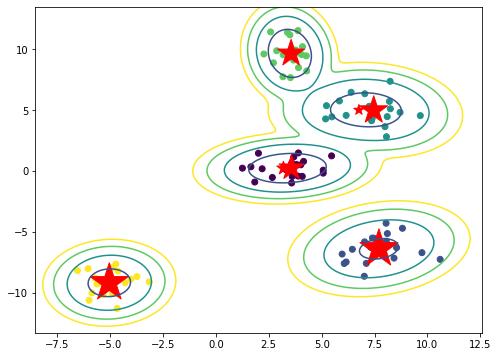

Iteration 1000


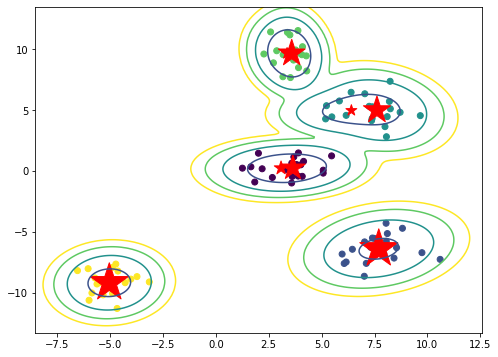

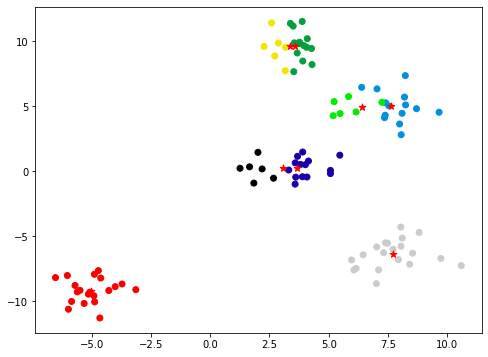

In [72]:
X, _C = sklearn.datasets.make_blobs(centers=5, n_features=2, n_samples=100, random_state=18)
plt.scatter(X[:,0], X[:,1], c=_C)
print("Data")
plt.show()
V = VI(2, X, _C, 100, 1, 0.01, 10, 0.05)
V.iterate(1000, [0, 1, 3, 9, 99, 999])
V.classifyPoints(True)